# Семинар: 3D-реконструкция, эпиполярная геометрия и глубина

В этом ноутбуке я шаг за шагом разбираю практические аспекты лекции:

1. **Параметрическая модель камеры** и перспективная проекция.
2. **Радиальная дисторсия**: как её смоделировать и как она портит картинку.
3. **Эпиполярная геометрия**: поиск соответствий, фундаментальная матрица, эпиполярные линии.
4. **Оценка глубины по одному изображению** (MiDaS / Depth Anything) и псевдо-3D.
5. **Контуры, визуальный тест Тьюринга и карты различий** между оригиналом и реконструкцией.
6. **Генерация по глубине** с помощью SD 1.5 + ControlNet Depth.

Семинар рассчитан на запуск в Google Colab с доступом к GPU.
Каждый блок можно использовать отдельно или последовательно как единый сценарий.


In [1]:
#@title Импорт основных библиотек

import math
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

print("OpenCV:", cv2.__version__)


OpenCV: 4.12.0


In [2]:
#@title Вспомогательные функции визуализации

def show_img(img: np.ndarray, title: str = "", cmap=None):
    """Удобная функция для вывода одиночного изображения (RGB / gray)."""
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


def show_row(images, titles=None, cmap=None, figsize=(20, 7)):
    """Отрисовка нескольких изображений в ряд."""
    n = len(images)
    titles = titles or [""] * n
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(images, titles), 1):
        plt.subplot(1, n, i)
        if im.ndim == 2:
            plt.imshow(im, cmap=cmap or "gray")
        else:
            plt.imshow(im)
        plt.axis("off")
        if t:
            plt.title(t)
    plt.tight_layout()
    plt.show()


## 2. Виртуальная камера и перспективная проекция

Сначала я хочу руками «пощупать» модель перспективной камеры,
о которой шла речь в лекции.

Я задам:

- матрицу внутренних параметров $K$ (фокусное расстояние и главный точка),
- внешние параметры $(R, t)$ — поворот и сдвиг камеры,
- набор 3D-точек (простая сцена: куб + плоскость).

Дальше реализую функцию перспективной проекции:

$$
\tilde{\mathbf{x}} = K [R \mid t] \tilde{\mathbf{X}}, \quad
\mathbf{x} = \left( \frac{u}{w}, \frac{v}{w} \right),
$$

и визуально посмотрю, как меняется изображение при различных
фокусных расстояниях и положениях камеры.


In [3]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

W, H = 800, 600
background = np.ones((H, W, 3), dtype=np.uint8) * 230  # светло-серый фон

def make_K(f: float = 800.0, cx: float = W/2, cy: float = H/2) -> np.ndarray:
    """Матрица внутренних параметров камеры."""
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]], dtype=np.float32)
    return K

def project_points_cam(K: np.ndarray, pts_cam: np.ndarray) -> np.ndarray:
    """
    Перспективная проекция, если точки уже заданы в системе камеры
    (ось Z вперёд, X вправо, Y вниз).
    pts_cam: Nx3 (Xc, Yc, Zc), Zc > 0.
    """
    X = pts_cam[:, 0]
    Y = pts_cam[:, 1]
    Z = pts_cam[:, 2]

    u = K[0, 0] * X / Z + K[0, 2]
    v = K[1, 1] * Y / Z + K[1, 2]
    return np.stack([u, v], axis=1)

def rot_y(theta_deg: float) -> np.ndarray:
    """Поворот вокруг вертикальной оси Y в системе камеры."""
    th = math.radians(theta_deg)
    c, s = math.cos(th), math.sin(th)
    R = np.array([[ c, 0, s],
                  [ 0, 1, 0],
                  [-s, 0, c]], dtype=np.float32)
    return R


In [4]:
def make_cube_cam(side: float = 2.0, center=(0.0, 0.0, 5.0)) -> np.ndarray:
    """
    Вершины куба в координатах камеры.
    Камера в (0,0,0), смотрит вдоль +Z, Y вниз.
    """
    cx, cy, cz = center
    s = side / 2.0
    # 8 вершин относительно центра
    offs = np.array([
        [-s, -s, -s],
        [ s, -s, -s],
        [ s,  s, -s],
        [-s,  s, -s],
        [-s, -s,  s],
        [ s, -s,  s],
        [ s,  s,  s],
        [-s,  s,  s],
    ], dtype=np.float32)
    pts = offs + np.array(center, dtype=np.float32)
    return pts  # (8, 3)

def make_floor_cam(x_range=(-2.0, 2.0), z_range=(3.0, 9.0), step=0.5, y=1.0) -> np.ndarray:
    """
    Точки "пола" (сетка) на высоте y (чуть ниже центра куба).
    """
    xs = np.arange(x_range[0], x_range[1] + 1e-5, step)
    zs = np.arange(z_range[0], z_range[1] + 1e-5, step)
    pts = []
    for X in xs:
        for Z in zs:
            pts.append([X, y, Z])
    return np.array(pts, dtype=np.float32)

cube_cam_base = make_cube_cam()
floor_cam     = make_floor_cam()
cube_cam_base.shape, floor_cam.shape


((8, 3), (117, 3))

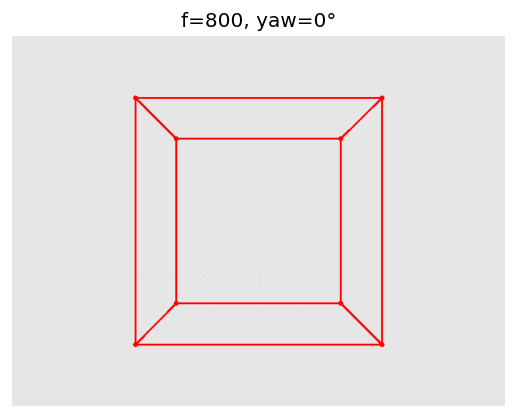

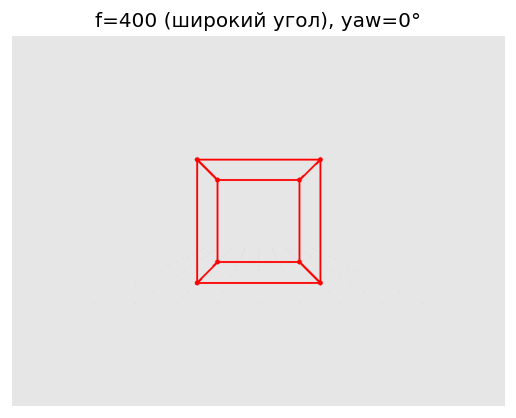

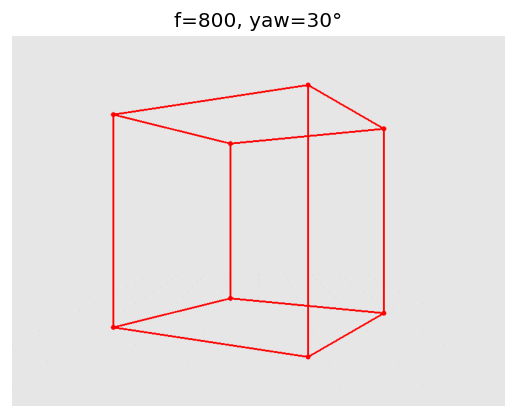

In [5]:
# индексы пар вершин, которые соединяем рёбрами
CUBE_EDGES = [
    (0, 1), (1, 2), (2, 3), (3, 0),   # передний прямоугольник
    (4, 5), (5, 6), (6, 7), (7, 4),   # задний прямоугольник
    (0, 4), (1, 5), (2, 6), (3, 7),   # вертикальные рёбра
]

def render_scene(f: float, yaw_deg: float, title: str):
    K = make_K(f=f, cx=W/2, cy=H/2)

    img = background.copy()

    # --- сетка пола (её не вращаем, она остаётся горизонтальной) ---
    floor_uv = project_points_cam(K, floor_cam)
    floor_uv_int = floor_uv.astype(int)
    for (u, v) in floor_uv_int:
        if 0 <= u < W and 0 <= v < H:
            img[v, u] = (200, 200, 200)

    # --- поворачиваем КУБ вокруг его собственного центра ---
    center = cube_cam_base.mean(axis=0)              # 3D-центр куба в координатах камеры
    R_yaw   = rot_y(yaw_deg)                         # поворот вокруг оси Y
    rel     = (cube_cam_base - center)               # координаты относительно центра
    cube_cam = (R_yaw @ rel.T).T + center            # повернули и вернули обратно к центру

    # проецируем повернутый куб
    cube_uv = project_points_cam(K, cube_cam)
    cube_uv_int = cube_uv.astype(int)

    # рёбра куба
    for i, j in CUBE_EDGES:
        u1, v1 = cube_uv_int[i]
        u2, v2 = cube_uv_int[j]
        if (0 <= u1 < W and 0 <= v1 < H and
            0 <= u2 < W and 0 <= v2 < H):
            cv2.line(img, (u1, v1), (u2, v2), (0, 0, 255), 2)

    # вершины куба
    for (u, v) in cube_uv_int:
        if 0 <= u < W and 0 <= v < H:
            cv2.circle(img, (u, v), 4, (0, 0, 255), -1)

    plt.figure()
    plt.imshow(img[..., ::-1])
    plt.axis("off")
    plt.title(title)
    plt.show()


render_scene(f=800, yaw_deg=0,  title="f=800, yaw=0°")
render_scene(f=400, yaw_deg=0,  title="f=400 (широкий угол), yaw=0°")
render_scene(f=800, yaw_deg=30, title="f=800, yaw=30°")


## 3. Радиальная дисторсия

Дальше я хочу показать, как в реальной камере на изображение
накладывается **радиальная дисторсия**.

В простейшей модели в нормализованных координатах $(x, y)$
мы умножаем их на коэффициент:

$$
r^2 = x^2 + y^2, \quad
x' = x (1 + k_1 r^2 + k_2 r^4), \quad
y' = y (1 + k_1 r^2 + k_2 r^4).
$$

Положительные коэффициенты дают «подушкообразную» дисторсию,
отрицательные — «бочкообразную».

Я сначала применю такую дисторсию к нашей синтетической сцене,
а потом покажу, как она проявляется на реальном изображении.


In [6]:
#@title Функция радиальной дисторсии в пиксельных координатах

def apply_radial_distortion(
    uv: np.ndarray,
    K: np.ndarray,
    k1: float = -0.2,
    k2: float = 0.0,
) -> np.ndarray:
    """
    Применяю радиальную дисторсию к пиксельным координатам (u, v),
    используя простую модель:

        x' = x (1 + k1 r^2 + k2 r^4)
        y' = y (1 + k1 r^2 + k2 r^4)

    uv: Nx2 (u, v) в пикселях
    K:  3x3 матрица внутренних параметров
    k1, k2: коэффициенты радиальной дисторсии.

    Возвращаю искажённые координаты u', v'.
    """
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]

    u = uv[:, 0]
    v = uv[:, 1]

    # нормализованные координаты
    x = (u - cx) / fx
    y = (v - cy) / fy

    r2 = x * x + y * y
    factor = 1.0 + k1 * r2 + k2 * r2 * r2

    x_d = x * factor
    y_d = y * factor

    u_d = x_d * fx + cx
    v_d = y_d * fy + cy

    return np.stack([u_d, v_d], axis=1)


Сначала я искажаю нашу «виртуальную» сцену.
Это позволяет наглядно увидеть, как дисторсия гнёт прямые линии.


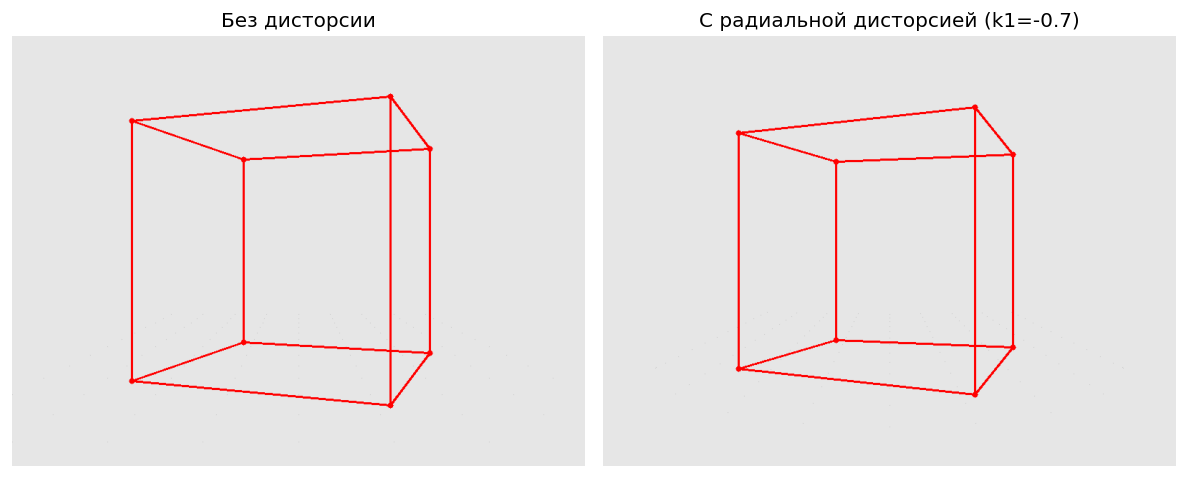

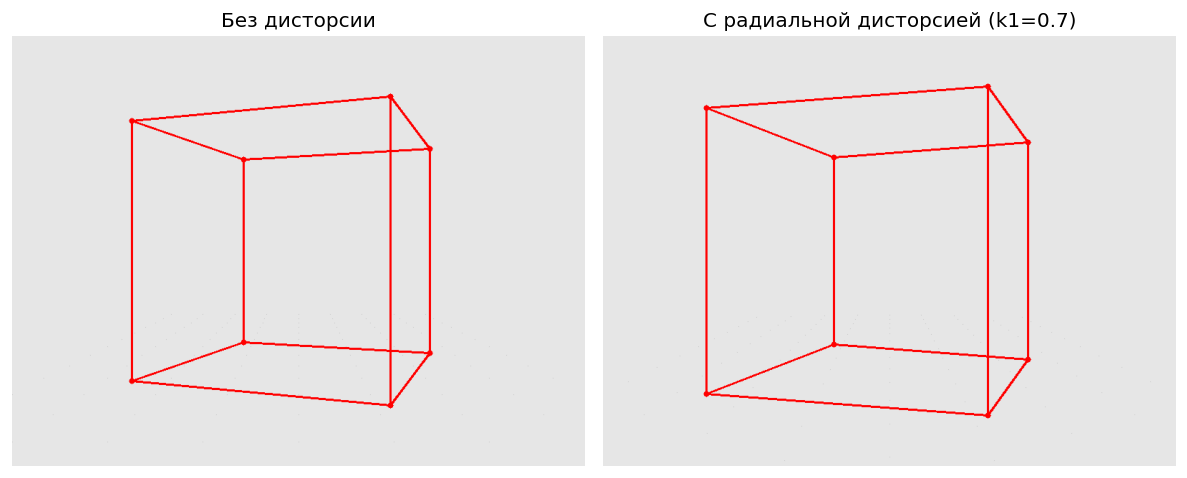

In [7]:
#@title Сцена с кубом: без дисторсии и с радиальной дисторсией

def render_scene_with_radial_distortion(k1: float = -0.3, yaw_deg: float = 20.0):
    """
    Рисую одну и ту же сцену двумя способами:

    - слева: идеальная перспектива без дисторсии;
    - справа: та же сцена, но к пиксельным координатам применена
      радиальная дисторсия с коэффициентом k1.

    yaw_deg — тот же поворот куба вокруг собственного центра,
    что и в блоке про перспективную проекцию.
    """
    K = make_K(f=800, cx=W/2, cy=H/2)

    # --- готовим камеру и геометрию куба ---
    # поворачиваем куб вокруг его центра
    center = cube_cam_base.mean(axis=0)
    R_yaw = rot_y(yaw_deg)
    rel = (cube_cam_base - center)
    cube_cam = (R_yaw @ rel.T).T + center

    # проекции без дисторсии
    floor_uv = project_points_cam(K, floor_cam)
    cube_uv  = project_points_cam(K, cube_cam)

    # проекции с дисторсией
    floor_uv_d = apply_radial_distortion(floor_uv, K, k1=k1)
    cube_uv_d  = apply_radial_distortion(cube_uv,  K, k1=k1)

    img_clean = background.copy()
    img_dist  = background.copy()

    # --- рисуем пол (сетку) ---
    for (u, v) in floor_uv.astype(int):
        if 0 <= u < W and 0 <= v < H:
            img_clean[v, u] = (200, 200, 200)

    for (u, v) in floor_uv_d.astype(int):
        if 0 <= u < W and 0 <= v < H:
            img_dist[v, u] = (200, 200, 200)

    # --- рисуем куб: рёбра и вершины ---
    cube_uv_int   = cube_uv.astype(int)
    cube_uv_d_int = cube_uv_d.astype(int)

    # рёбра без дисторсии
    for i, j in CUBE_EDGES:
        u1, v1 = cube_uv_int[i]
        u2, v2 = cube_uv_int[j]
        if (0 <= u1 < W and 0 <= v1 < H and
            0 <= u2 < W and 0 <= v2 < H):
            cv2.line(img_clean, (u1, v1), (u2, v2), (0, 0, 255), 2)

    # рёбра с дисторсией
    for i, j in CUBE_EDGES:
        u1, v1 = cube_uv_d_int[i]
        u2, v2 = cube_uv_d_int[j]
        if (0 <= u1 < W and 0 <= v1 < H and
            0 <= u2 < W and 0 <= v2 < H):
            cv2.line(img_dist, (u1, v1), (u2, v2), (0, 0, 255), 2)

    # вершины
    for (u, v) in cube_uv_int:
        if 0 <= u < W and 0 <= v < H:
            cv2.circle(img_clean, (u, v), 4, (0, 0, 255), -1)

    for (u, v) in cube_uv_d_int:
        if 0 <= u < W and 0 <= v < H:
            cv2.circle(img_dist, (u, v), 4, (0, 0, 255), -1)

    # показываем side-by-side
    show_row(
        [img_clean[..., ::-1], img_dist[..., ::-1]],
        ["Без дисторсии", f"С радиальной дисторсией (k1={k1})"],
        figsize=(10, 4),
    )


# пример более сильной дисторсии и большего куба
render_scene_with_radial_distortion(k1=-0.7, yaw_deg=20.0)
render_scene_with_radial_distortion(k1=+0.7, yaw_deg=20.0)


## Эпиполярная геометрия: соответствия, фундаментальная матрица и линии

В этом блоке я показываю практическую реализацию идей из раздела
про эпиполярную геометрию:

1. Беру пару перекрывающихся изображений одной сцены.
2. Нахожу ключевые точки и соответствия (ORB + BFMatcher).
3. Оцениваю фундаментальную матрицу `F` с помощью RANSAC.
4. Рисую эпиполярные линии на одном изображении для точек с другого.
5. Считаю эпиполярную ошибку $$x_2^T F x_1 $$ и сравниваю инлайеры/аутлайеры.


In [8]:
#@title Универсальная загрузка стереопары (Colab upload или пути)

import cv2
import numpy as np

def load_stereo_pair_from_paths(path_left,
                                path_right=None,
                                pair_in_one=False,
                                split_orientation='vertical',
                                cut_border=0):
    """
    Загрузка стереопары с диска по путям.

    Если pair_in_one=False:
        path_left  – путь к левому изображению
        path_right – путь к правому изображению

    Если pair_in_one=True:
        path_left  – путь к ОДНОМУ файлу, внутри которого левое и правое
                     изображение размещены рядом или друг над другом.
        path_right – игнорируется.

    split_orientation : {'vertical', 'horizontal'}
        'vertical'   – левое и правое стоят рядом (|L|R|).
        'horizontal' – левое над правым.
    cut_border : int
        Сколько пикселей отрезать вокруг линии раздела
        (иногда по центру есть чёрная/серая полоска).
    """
    if not pair_in_one:
        if path_right is None:
            raise ValueError("При pair_in_one=False нужно указать path_right.")
        img_left  = cv2.imread(path_left,  cv2.IMREAD_COLOR)
        img_right = cv2.imread(path_right, cv2.IMREAD_COLOR)
        if img_left is None or img_right is None:
            raise IOError("Не удалось загрузить одно из изображений.")
        return img_left, img_right

    # режим «оба в одном»
    img = cv2.imread(path_left, cv2.IMREAD_COLOR)
    if img is None:
        raise IOError(f"Не удалось загрузить изображение: {path_left}")

    h, w = img.shape[:2]

    if split_orientation == 'vertical':
        mid = w // 2
        left  = img[:, cut_border:mid - cut_border]
        right = img[:, mid + cut_border:w - cut_border]
    else:  # 'horizontal'
        mid = h // 2
        left  = img[cut_border:mid - cut_border, :]
        right = img[mid + cut_border:h - cut_border, :]

    return left, right


def get_stereo_pair(use_upload: bool = True,
                    pair_in_one: bool = False,
                    split_orientation: str = 'vertical',
                    cut_border: int = 0,
                    path_left: str = None,
                    path_right: str = None):
    """
    Высокоуровневая функция:

    - если use_upload=True: использует google.colab.files.upload()
      и определяет, что/как загрузили;
    - если use_upload=False: читает с диска по path_left / path_right.

    Возвращает:
        img_left_bgr, img_right_bgr
    """
    if use_upload:
        try:
            from google.colab import files
        except ImportError:
            raise RuntimeError("google.colab.files недоступен (не Colab). "
                               "Установите use_upload=False и задайте пути.")

        if pair_in_one:
            print("Загрузите ОДИН файл, содержащий левое и правое изображение.")
        else:
            print("Загрузите два файла: left.jpg и right.jpg (или переименуйте свои).")

        uploaded = files.upload()
        names = list(uploaded.keys())
        if not names:
            raise RuntimeError("Файлы не были загружены.")

        if pair_in_one:
            # берём просто первый файл как стереопару в одном
            stereo_path = names[0]
            print(f"Использую файл '{stereo_path}' как стереопару (оба в одном).")
            return load_stereo_pair_from_paths(
                stereo_path,
                pair_in_one=True,
                split_orientation=split_orientation,
                cut_border=cut_border,
            )
        else:
            # пытаемся угадать left/right по имени
            left_candidates  = [n for n in names if "left"  in n.lower()]
            right_candidates = [n for n in names if "right" in n.lower()]

            if left_candidates and right_candidates:
                left_name  = left_candidates[0]
                right_name = right_candidates[0]
            elif len(names) >= 2:
                left_name, right_name = names[0], names[1]
                print("Не удалось однозначно распознать left/right по имени, "
                      "использую первые два файла:", left_name, right_name)
            else:
                raise RuntimeError("Для раздельного режима нужно как минимум два файла.")

            print(f"Левое: '{left_name}', правое: '{right_name}'")
            return load_stereo_pair_from_paths(
                left_name,
                right_name,
                pair_in_one=False,
            )

    # use_upload == False → читаем по путям
    if path_left is None:
        raise ValueError("При use_upload=False нужно задать path_left (и при необходимости path_right).")

    return load_stereo_pair_from_paths(
        path_left=path_left,
        path_right=path_right,
        pair_in_one=pair_in_one,
        split_orientation=split_orientation,
        cut_border=cut_border,
    )


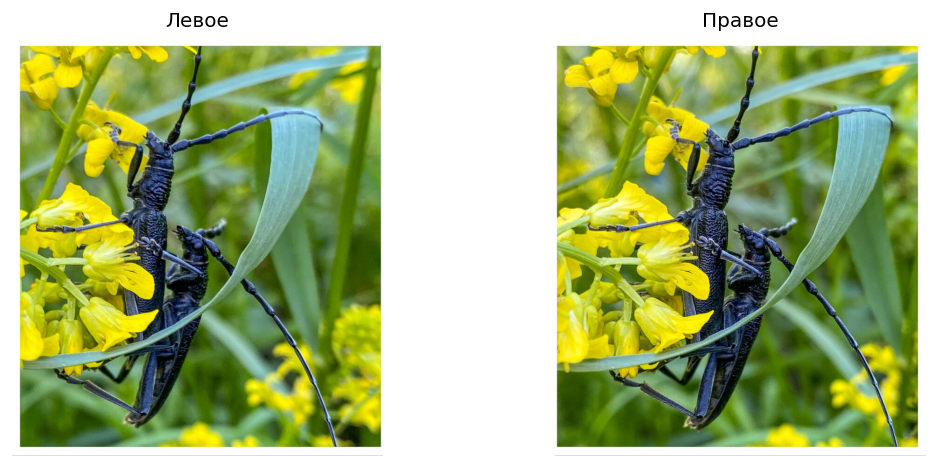

In [13]:
#@title Загрузка пары с диска
imgL_bgr, imgR_bgr = get_stereo_pair(
    use_upload=False,
    pair_in_one=True,             # или False, если два файла
    split_orientation='vertical',
    cut_border=2,
    path_left="/content/Stereo-to-go-7.jpeg", # для pair_in_one
    # path_right="right.png",     # для pair_in_one=False
)

imgL_rgb = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

show_row([imgL_rgb, imgR_rgb], ["Левое", "Правое"], figsize=(10,4))


Загрузите два файла: left.jpg и right.jpg (или переименуйте свои).


Saving 2.jpg to 2.jpg
Saving 1.jpg to 1.jpg
Не удалось однозначно распознать left/right по имени, использую первые два файла: 2.jpg 1.jpg
Левое: '2.jpg', правое: '1.jpg'


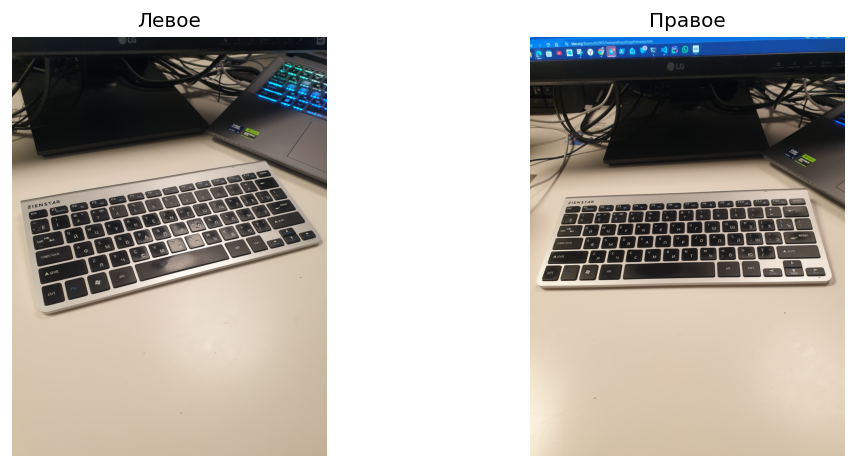

In [10]:
#@title Загрузка пары из двух файлов через Colab
imgL_bgr, imgR_bgr = get_stereo_pair(
    use_upload=True,
    pair_in_one=False,   # два отдельных файла
)

imgL_rgb = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

show_row([imgL_rgb, imgR_rgb], ["Левое", "Правое"], figsize=(10,4))


Загрузите ОДИН файл, содержащий левое и правое изображение.


Saving CosimaHeadStereoPairMid.jpg to CosimaHeadStereoPairMid (1).jpg
Использую файл 'CosimaHeadStereoPairMid (1).jpg' как стереопару (оба в одном).


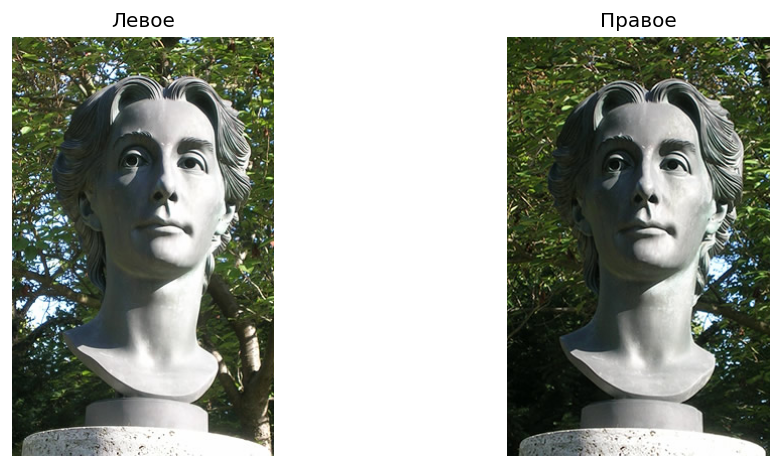

In [14]:
#@title Загрузка пары из одного файла через Colab
imgL_bgr, imgR_bgr = get_stereo_pair(
    use_upload=True,          # хотим загрузку через files.upload()
    pair_in_one=True,         # оба кадра в одном файле
    split_orientation='vertical',  # левое и правое стоят рядом
    cut_border=2              # немного обрежем центральную границу
)

imgL_rgb = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

show_row([imgL_rgb, imgR_rgb], ["Левое", "Правое"], figsize=(10,4))


In [15]:
#@title Поиск соответствий (ORB + BFMatcher) и оценка фундаментальной матрицы

imgL_gray = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2GRAY)

# ORB
orb = cv2.ORB_create(2000)
kp1, des1 = orb.detectAndCompute(imgL_gray, None)
kp2, des2 = orb.detectAndCompute(imgR_gray, None)

print(f"Найдено ключевых точек: {len(kp1)} (левое), {len(kp2)} (правое)")

# матчинг по Hamming
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda m: m.distance)

print("Всего совпадений:", len(matches))

# берём N лучших матчей
N = min(500, len(matches))
good_matches = matches[:N]

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# RANSAC для фундаментальной матрицы
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
inliers_mask = mask.ravel().astype(bool)

print("Фундаментальная матрица F:\n", F)
print(f"Инлайеров по RANSAC: {inliers_mask.sum()} из {len(inliers_mask)}")

pts1_in = pts1[inliers_mask]
pts2_in = pts2[inliers_mask]


Найдено ключевых точек: 1453 (левое), 1530 (правое)
Всего совпадений: 504
Фундаментальная матрица F:
 [[-2.60442446e-06  8.41430302e-05 -2.11522645e-02]
 [-6.78584190e-05  6.88880660e-06 -8.28806784e-02]
 [ 1.50764983e-02  7.97474464e-02  1.00000000e+00]]
Инлайеров по RANSAC: 302 из 500


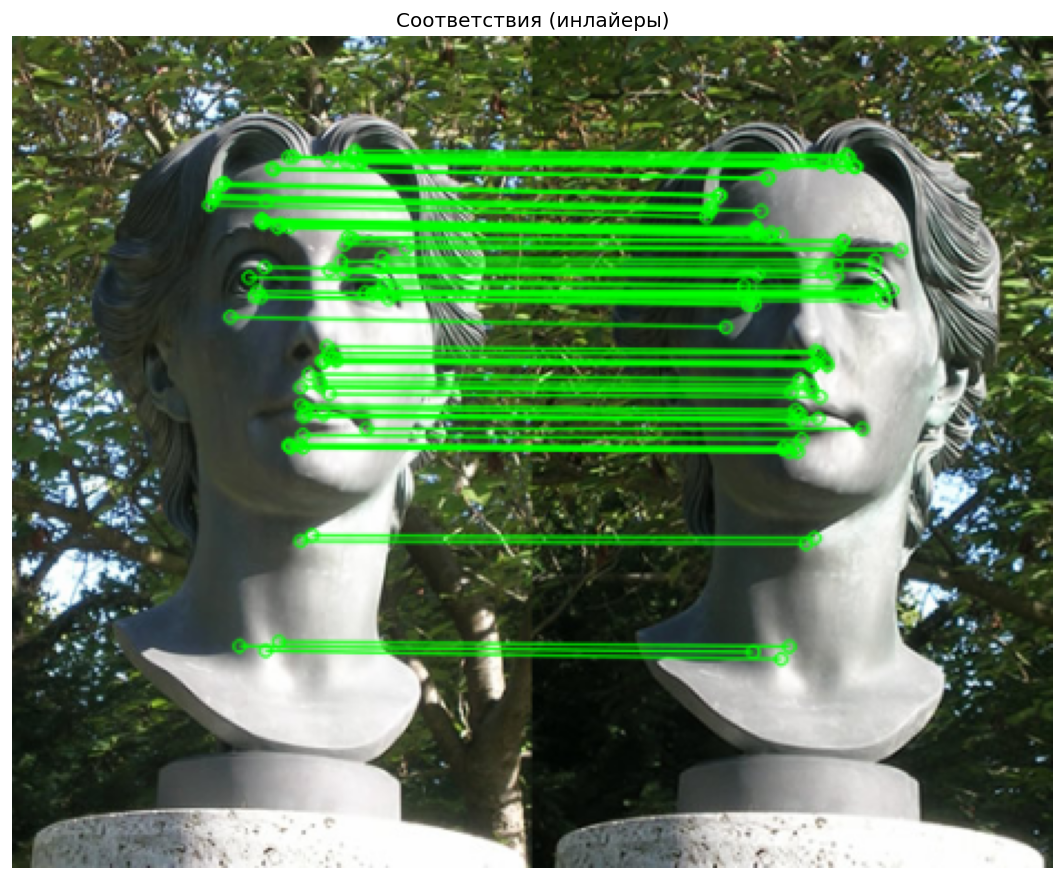

In [16]:
#@title Визуализация соответствий (толстые линии, масштаб, figsize)
import matplotlib.pyplot as plt

def draw_matches(img1, kp1, img2, kp2,
                 matches, mask=None,
                 max_draw=80,
                 scale=0.9,
                 figsize=(18, 9),
                 title="Соответствия (инлайеры)"):
    """
    Визуализация матчей:
    - яркие зелёные линии,
    - возможность масштабирования итоговой картинки,
    - настраиваемый размер фигуры.
    """
    if mask is not None:
        matches = [m for m, keep in zip(matches, mask.ravel().tolist()) if keep]
    matches = matches[:max_draw]

    vis = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        matches, None,
        matchColor=(0, 255, 0),                 # ярко-зелёные линии
        singlePointColor=(255, 0, 0),           # точки — красные
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    # масштабирование итогового изображения (если нужно)
    if scale != 1.0:
        h, w = vis.shape[:2]
        vis = cv2.resize(
            vis,
            (int(w * scale), int(h * scale)),
            interpolation=cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
        )

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()


draw_matches(imgL_bgr, kp1, imgR_bgr, kp2, good_matches, mask)


# Визуализация эпиполярных линий

### Точки-инлайеры и эпиполярные линии

В этой ячейке я визуализирую эпиполярную геометрию на реальной стереопаре.

1. **Выбор инлайеров.**  
   Из всех найденных соответствий (ORB + BFMatcher) я оставляю только те пары точек, которые прошли через RANSAC при оценке фундаментальной матрицы `F`. Это «хорошие» соответствия, согласующиеся с эпиполярным ограничением.

2. **Левое изображение (слева).**  
   На левом кадре я рисую эти точки-инлайеры в виде цветных кругов.  
   Каждая точка сцены получает свой цвет (красный, синий, зелёный и т.п.).  
   Обратите внимание, что точки лежат на информативных деталях — уголки глаз, нос, рот, контур головы — там, где дескрипторы легко сопоставить между кадрами.

3. **Правое изображение (справа).**  
   Для каждой точки $\mathbf{x}_1$ на левом изображении я рассчитываю соответствующую **эпиполярную прямую** на правом изображении:
   $$
   \mathbf{l}_2 = F \, \tilde{\mathbf{x}}_1,
   $$
   где $\tilde{\mathbf{x}}_1$ — однородные координаты точки.  
   На правом кадре я рисую прямую того же цвета, что и исходная точка.  
   Эта линия показывает *все возможные положения* соответствующей точки на правом изображении.

4. **Интерпретация.**  
   Видно, что все эпиполярные линии почти параллельны и имеют близкий наклон — камеры стоят примерно на одной горизонтали, но ещё не ректифицированы.  
   Эту же информацию мы далее используем для ректификации стереопары и построения карты диспаритета.

Таким образом, эта визуализация связывает найденные соответствия (инлайеры) с фундаментальной матрицей и наглядно показывает, как эпиполярное ограничение геометрически проявляется на изображениях.




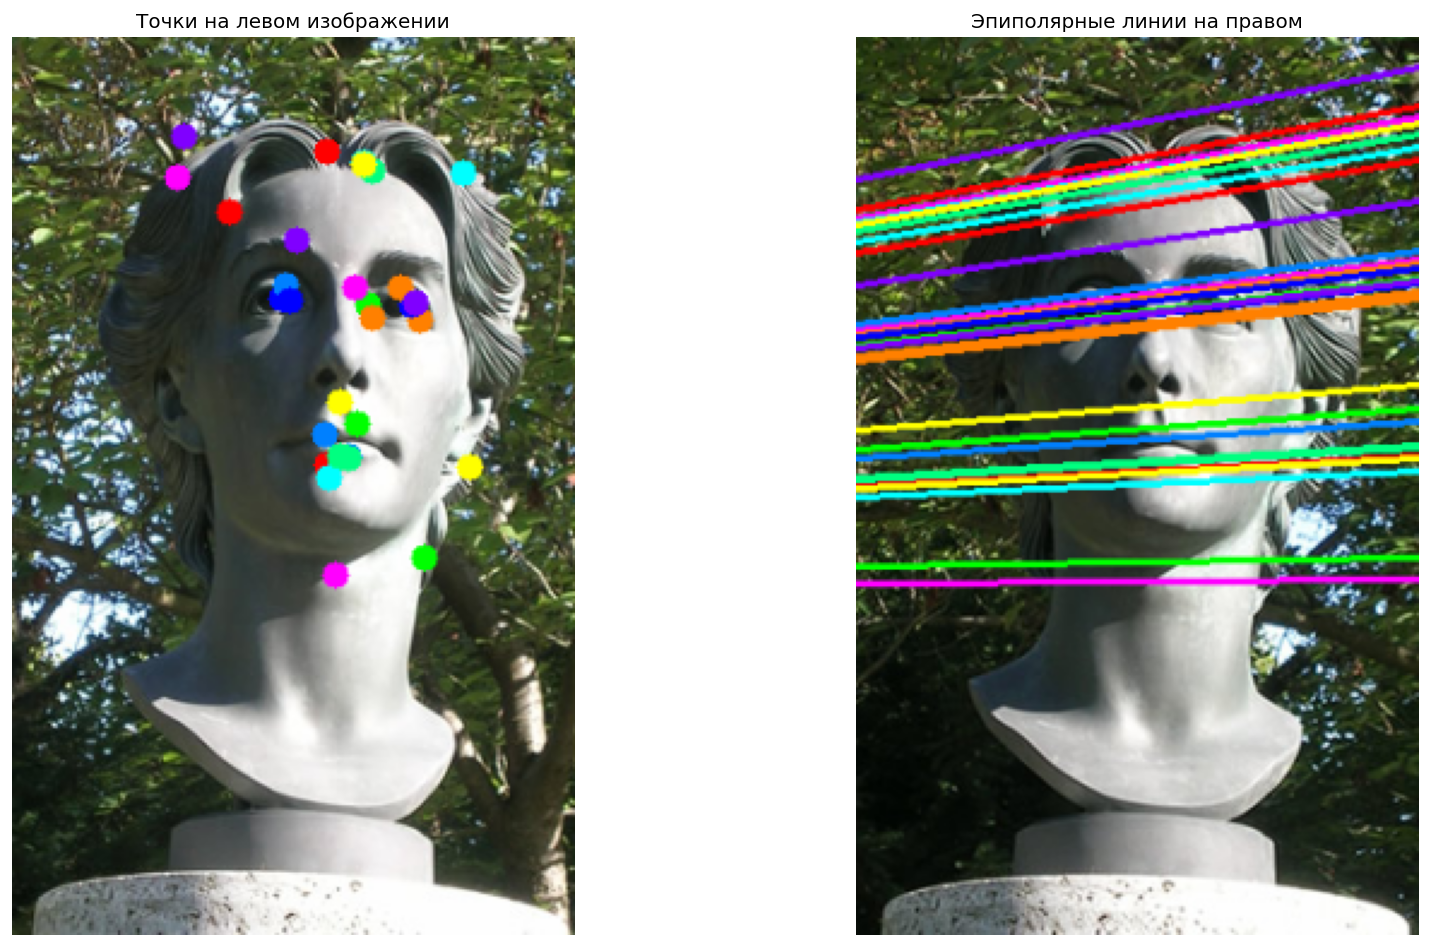

In [17]:

def draw_epipolar_lines(img1_rgb, img2_rgb, F,
                        pts1, pts2,
                        num_lines=15,
                        scale=0.9,
                        figsize=(12, 5),
                        title_left="Точки на левом изображении",
                        title_right="Эпиполярные линии на правом"):
    """
    Рисуем точки на первом изображении и соответствующие эпиполярные линии
    на втором. Линии делаем толще и ярче, плюс поддерживаем масштаб и figsize.
    """
    img1 = img1_rgb.copy()
    img2 = img2_rgb.copy()

    h2, w2 = img2.shape[:2]

    # случайно выбираем несколько инлайеров
    n = min(num_lines, len(pts1))
    idx = np.random.choice(len(pts1), size=n, replace=False)
    pts1_s = pts1[idx]
    pts2_s = pts2[idx]

    # однородные координаты точек с первого изображения
    pts1_h = np.hstack([pts1_s, np.ones((n, 1), dtype=np.float32)])  # Nx3
    lines2 = (F @ pts1_h.T).T  # Nx3

    # набор ярких цветов (BGR) по кругу
    colors = [
        (255, 0, 0),    # синий в RGB, но красный в BGR? напомним: cv2 → BGR
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (255, 0, 255),
        (0, 255, 255),
        (128, 0, 255),
        (0, 128, 255),
        (255, 128, 0),
        (0, 255, 128),
    ]

    for k, ((x1, y1), (a, b, c)) in enumerate(zip(pts1_s, lines2)):
        color = colors[k % len(colors)]

        # точка на первом изображении
        cv2.circle(img1, (int(x1), int(y1)), 6, color, -1)

        # эпиполярная линия на правом изображении: a x + b y + c = 0
        if abs(b) > 1e-6:
            x0, y0 = 0, int(-c / b)
            x1_, y1_ = w2, int(-(c + a * w2) / b)
        else:
            x0 = x1_ = int(-c / a)
            y0, y1_ = 0, h2

        cv2.line(img2, (x0, y0), (x1_, y1_), color, 2)  # линия потолще

    # масштабируем оба изображения, если нужно
    if scale != 1.0:
        def resize_im(im):
            h, w = im.shape[:2]
            return cv2.resize(
                im,
                (int(w * scale), int(h * scale)),
                interpolation=cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
            )
        img1 = resize_im(img1)
        img2 = resize_im(img2)

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis("off")
    plt.title(title_left)

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis("off")
    plt.title(title_right)

    plt.tight_layout()
    plt.show()

draw_epipolar_lines(
    imgL_rgb, imgR_rgb, F,
    pts1_in, pts2_in,
    num_lines=30,
    scale=0.9,
    figsize=(16, 8),
)


# Ректификация стереопары по фундаментальной матрице (uncalibrated)

### Ректификация стереопары

В этой ячейке я выполняю **ректификацию** левого и правого изображений — то есть такое преобразование, при котором эпиполярные линии становятся *горизонтальными*, а соответствующие точки оказываются примерно на одной строке.

1. **Входные данные.**  
   Я использую:
   - найденные ранее инлайеры $\{\mathbf{x}_1, \mathbf{x}_2\}$,
   - фундаментальную матрицу $F$, оценённую с помощью RANSAC.

2. **Оценка гомографий.**  
   С помощью функции `cv2.stereoRectifyUncalibrated` по паре точек и матрице $F$ я нахожу две проективные гомографии:
   $$
   H_1,\, H_2 \in \mathbb{R}^{3\times 3},
   $$
   которые переводят исходные изображения в новую систему координат так, что эпиполярные линии становятся параллельными строкам.

   Для каждой точки выполняется преобразование:
   $$
   \tilde{\mathbf{x}}_1' \sim H_1 \tilde{\mathbf{x}}_1,\qquad
   \tilde{\mathbf{x}}_2' \sim H_2 \tilde{\mathbf{x}}_2.
   $$

3. **Применение преобразований.**  
   Я применяю $H_1$ и $H_2$ к левому и правому изображениям с помощью `cv2.warpPerspective` и получаю ректифицированные кадры.  
   На картинке видно, что:
   - изображения стали как бы «наклонёнными» внутри чёрного прямоугольника;
   - появляются **чёрные поля** — области, где после проективного преобразования нет данных.

4. **Интерпретация результата.**  
   Несмотря на геометрические искажения по краям, важное свойство выполнено:  
   после ректификации соответствующие точки в двух изображениях лежат примерно **на одной строке**.  
   Это значит, что для поиска соответствий в дальнейшем можно рассматривать только смещения вдоль оси $x$ (по строке) и строить карту диспаритета, что существенно упрощает задачу плотной стереореконструкции.


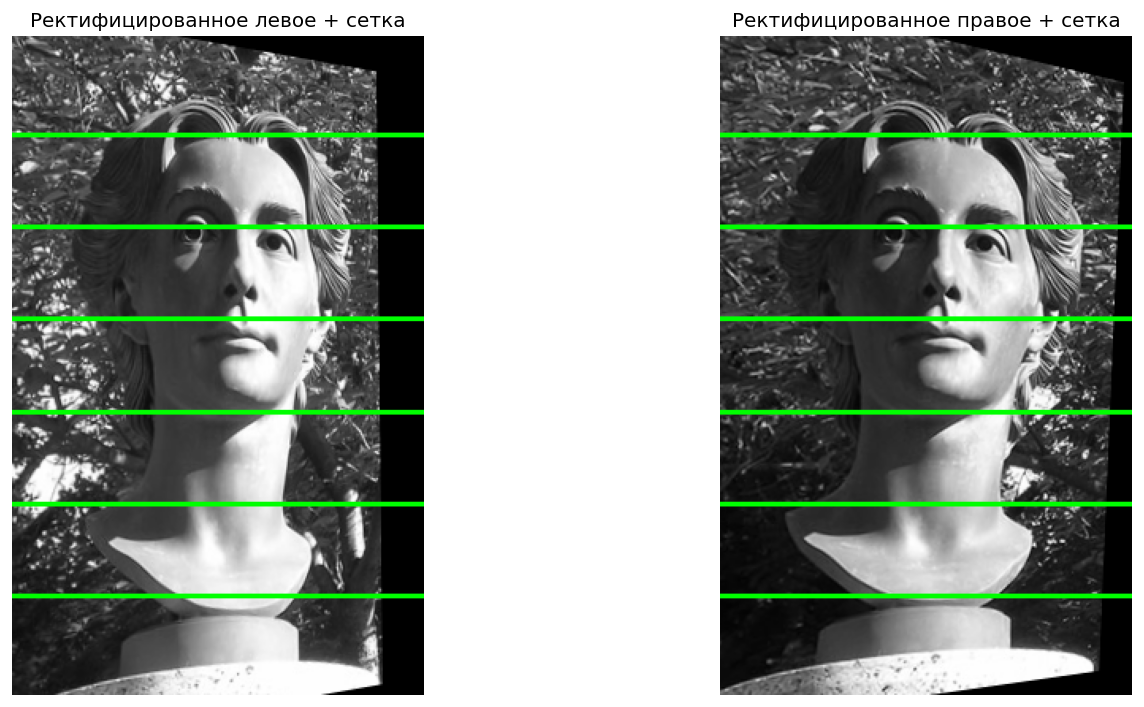

In [20]:
# Ректификация стереопары по F
def rectify_uncalibrated(imgL_gray, imgR_gray, pts1_in, pts2_in, F):
    h, w = imgL_gray.shape[:2]
    retval, H1, H2 = cv2.stereoRectifyUncalibrated(
        pts1_in, pts2_in, F, imgSize=(w, h)
    )
    if not retval:
        raise RuntimeError("stereoRectifyUncalibrated не смогла ректифицировать пару.")

    rectL = cv2.warpPerspective(imgL_gray, H1, (w, h))
    rectR = cv2.warpPerspective(imgR_gray, H2, (w, h))
    return rectL, rectR, H1, H2


rectL_gray, rectR_gray, H1, H2 = rectify_uncalibrated(
    imgL_gray, imgR_gray, pts1_in, pts2_in, F
)

# Функция для отрисовки горизонтальных линий на ректифицированных изображениях
def draw_rectified_with_grid(rectL_gray, rectR_gray,
                             n_lines: int = 6,
                             color=(0, 255, 0),
                             thickness: int = 2):
    """
    Рисую несколько горизонтальных линий поверх ректифицированных изображений,
    чтобы подчеркнуть, что эпиполярные линии совпадают со строками.
    """
    h, w = rectL_gray.shape[:2]

    # конвертируем в BGR, чтобы линии были цветными
    visL = cv2.cvtColor(rectL_gray, cv2.COLOR_GRAY2BGR)
    visR = cv2.cvtColor(rectR_gray, cv2.COLOR_GRAY2BGR)

    # выбираем несколько уровней по высоте (без самых краёв)
    ys = np.linspace(0.15 * h, 0.85 * h, n_lines).astype(int)

    for y in ys:
        cv2.line(visL, (0, y), (w - 1, y), color, thickness)
        cv2.line(visR, (0, y), (w - 1, y), color, thickness)

    show_row(
        [cv2.cvtColor(visL, cv2.COLOR_BGR2RGB),
         cv2.cvtColor(visR, cv2.COLOR_BGR2RGB)],
        ["Ректифицированное левое + сетка",
         "Ректифицированное правое + сетка"],
        figsize=(14, 6)
    )

draw_rectified_with_grid(rectL_gray, rectR_gray)


# Расчёт карты диспаритета StereoSGBM

### Карта диспаритета (StereoSGBM)

В этой ячейке я строю **плотную карту диспаритета** по ректифицированной стереопаре
с помощью алгоритма `cv2.StereoSGBM`.

1. **Входные данные.**  
   На вход подаются ректифицированные изображения в градациях серого  
   `rectL_gray` и `rectR_gray`. После ректификации эпиполярные линии совпадают
   со строками, поэтому поиск соответствий ведётся вдоль горизонтали.

2. **StereoSGBM.**  
   Я создаю объект `StereoSGBM` и задаю основные параметры:
   - `minDisparity` — минимальное значение диспаритета;
   - `numDisparities` — диапазон поиска (кратен 16), фактически максимальный сдвиг по $x$;
   - `blockSize` — размер окна сопоставления (чем больше окно, тем сильнее сглаживание);
   - параметры гладкости `P1`, `P2`, порог `uniquenessRatio` и т.д.

   Алгоритм для каждого пикселя левого изображения ищет позицию на правом,
   при которой окно вокруг пикселя даёт наименькую стоимость по сумме
   абсолютных/квадратичных разностей, с учётом штрафов за резкие скачки диспаритета.

3. **Результат.**  
   Функция `stereo.compute` возвращает карту целочисленных значений диспаритета,
   которую я нормализую и визуализирую в виде псевдоцветового изображения.
   Чем больше значение диспаритета (сдвиг между левым и правым кадром),
   тем **ближе** находится точка к камере:
   $$
   Z \propto \frac{1}{d},
   $$
   где $d$ — диспаритет в пикселях.

4. **Интерпретация текущей карты.**  
   На карте хорошо выделяется силуэт бюста: он отображается как область
   с большими значениями диспаритета (яркие жёлто-оранжевые цвета),
   тогда как дальний фон имеет малый диспаритет (тёмно-синий).  
   Обратите внимание, что на гладких или плохо текстурированных областях
   алгоритм даёт пробелы и шум — это нормальное поведение классического стерео.

Эта карта диспаритета будет использована далее для построения грубого
3D-облака точек и иллюстрации перехода от двух 2D-изображений к
трёхмерному представлению сцены.


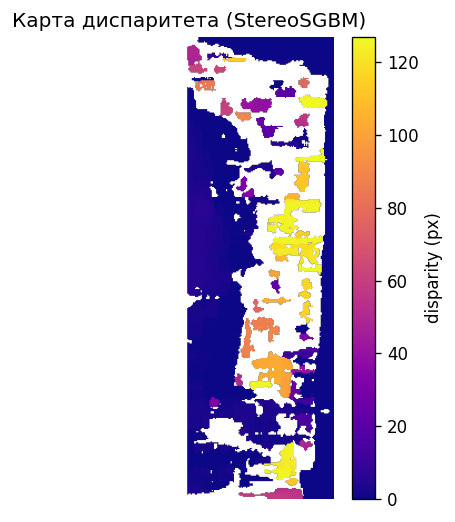

In [24]:
if 'rectL_gray' in globals():
    num_disparities = 16 * 8
    block_size      = 7
    min_disparity   = 0

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * block_size ** 2,
        P2=32 * 3 * block_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=1,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )

    disp = stereo.compute(rectL_gray, rectR_gray).astype(np.float32) / 16.0
    disp[disp < min_disparity] = np.nan

    plt.figure(figsize=(4,5))
    plt.imshow(disp, cmap="plasma")
    plt.colorbar(label="disparity (px)")
    plt.title("Карта диспаритета (StereoSGBM)")
    plt.axis("off")
    plt.show()


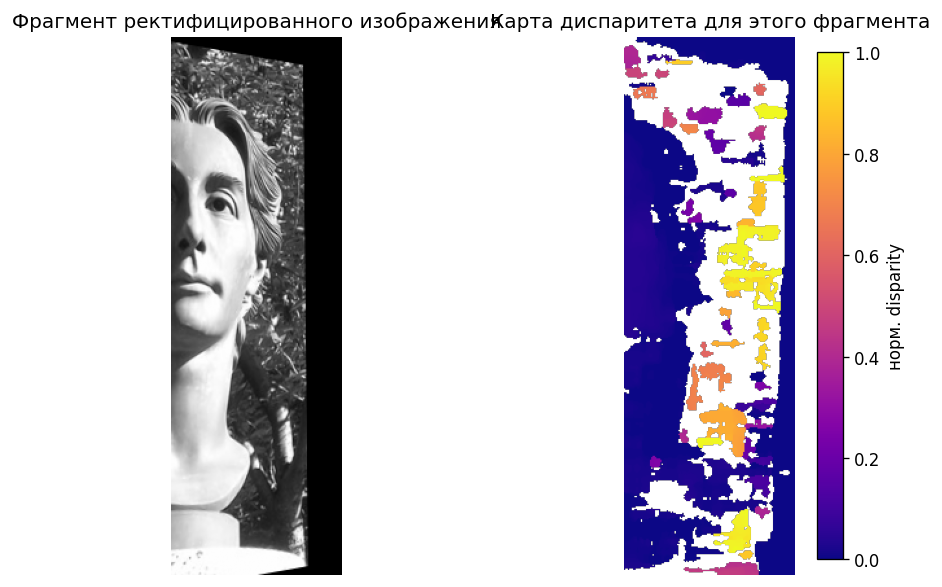

In [25]:
#@title Визуализация: фрагмент изображения + карта диспаритета


def show_disparity_with_image_crop(rectL_gray, disp,
                                   figsize=(8, 5),
                                   cmap="plasma"):
    """
    Ищу область с валидным диспаритетом и показываю:
    - соответствующий фрагмент ректифицированного левого изображения,
    - карту диспаритета для этого же фрагмента.
    """
    # маска валидных значений
    mask_valid = ~np.isnan(disp)
    if not np.any(mask_valid):
        raise RuntimeError("В карте диспаритета нет валидных значений.")

    ys, xs = np.where(mask_valid)
    y_min, y_max = ys.min(), ys.max() + 1
    x_min, x_max = xs.min(), xs.max() + 1

    # вырезаем одинаковый прямоугольник
    crop_img  = rectL_gray[y_min:y_max, x_min:x_max]
    crop_disp = disp[y_min:y_max, x_min:x_max]

    # нормализация диспаритета внутри фрагмента (для более контрастной палитры)
    disp_min = np.nanmin(crop_disp)
    disp_max = np.nanmax(crop_disp)
    disp_norm = (crop_disp - disp_min) / (disp_max - disp_min + 1e-6)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].imshow(crop_img, cmap="gray")
    axes[0].set_title("Фрагмент ректифицированного изображения")
    axes[0].axis("off")

    im = axes[1].imshow(disp_norm, cmap=cmap)
    axes[1].set_title("Карта диспаритета для этого фрагмента")
    axes[1].axis("off")
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="норм. disparity")

    plt.tight_layout()
    plt.show()

show_disparity_with_image_crop(rectL_gray, disp)


# Фрагмент изображения и облако точек с привязкой выбранных пикселей

### Облако точек из карты диспаритета

В этой ячейке я показываю, как карта диспаритета превращается
в **трёхмерное облако точек**.

1. **Тот же фрагмент, что и раньше.**  
   Сначала я снова нахожу область, в которой диспаритет определён
   (маска валидных значений) и вырезаю одинаковый прямоугольник
   из ректифицированного изображения и из карты диспаритета.
   Это ровно тот же фрагмент, который мы только что видели
   на паре «изображение + disparity».

2. **Переход от disparity к глубине.**  
   Для каждого пикселя фрагмента я беру координату $(x, y)$ и диспаритет $d$.
   По самой простой модели глубина обратно пропорциональна диспаритету:
   $$
   Z \propto \frac{1}{d}.
   $$
   Я нормирую $X, Y, Z$, чтобы точки компактно помещались в единичный куб,
   и получаю набор $(X, Y, Z)$ — это и есть 3D-облако.

3. **Визуализация.**  
   Слева я показываю фрагмент ректифицированного изображения,
   справа — облако точек, раскрашенное по относительной глубине (чем светлее,
   тем ближе к камере).  
   Хорошо видно, что точки, принадлежащие бюсту, образуют «ближний слой»,
   а фон — более дальний слой.

Таким образом, мы последовательно прошли цепочку:
две ректифицированные картинки → карта диспаритета → оценка глубины → 3D-облако,
то есть получили простейшую трёхмерную реконструкцию сцены из стереопары.


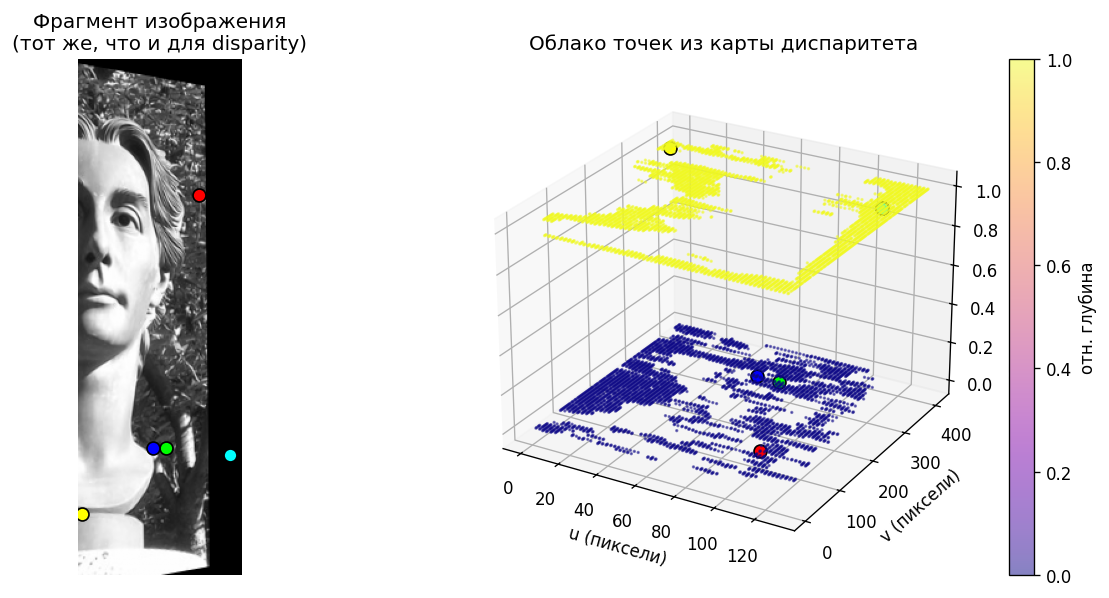

In [26]:

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def get_valid_crop_bounds(disp):
    mask_valid = ~np.isnan(disp)
    if not np.any(mask_valid):
        raise RuntimeError("В карте диспаритета нет валидных значений.")
    ys, xs = np.where(mask_valid)
    y_min, y_max = ys.min(), ys.max() + 1
    x_min, x_max = xs.min(), xs.max() + 1
    return y_min, y_max, x_min, x_max


def disparity_to_point_cloud_pixels(crop_disp, step=2, max_points=8000):
    """
    Облако точек с X,Y в координатах пикселей (в пределах crop),
    Z ~ 1 / disparity, нормализованный в [0,1].
    """
    h, w = crop_disp.shape

    ys, xs = np.mgrid[0:h:step, 0:w:step]
    ds = crop_disp[0:h:step, 0:w:step]

    mask = ~np.isnan(ds)
    xs = xs[mask].astype(np.float32)
    ys = ys[mask].astype(np.float32)
    ds = ds[mask].astype(np.float32)

    if len(xs) == 0:
        raise RuntimeError("После прореживания и маски нет валидных точек.")

    Z = 1.0 / (ds + 1e-6)
    Z = (Z - Z.min()) / (Z.max() - Z.min() + 1e-6)

    if len(xs) > max_points:
        idx = np.random.choice(len(xs), size=max_points, replace=False)
        xs, ys, Z = xs[idx], ys[idx], Z[idx]

    return xs, ys, Z


def show_point_cloud_with_anchors(rectL_gray, disp,
                                  step=2, max_points=8000,
                                  n_anchors_foreground=3,
                                  n_anchors_background=3,
                                  figsize=(11, 5)):
    """
    Слева: фрагмент ректифицированного изображения + несколько цветных точек.
    Справа: облако точек из карты диспаритета, те же точки в 3D
    отмечены теми же цветами.
    """
    # 1) находим границы фрагмента
    y_min, y_max, x_min, x_max = get_valid_crop_bounds(disp)
    crop_img  = rectL_gray[y_min:y_max, x_min:x_max]
    crop_disp = disp[y_min:y_max, x_min:x_max]

    h, w = crop_img.shape

    # 2) облако точек (X,Y в пикселях кожрдинат crop)
    X, Y, Z = disparity_to_point_cloud_pixels(crop_disp, step=step, max_points=max_points)

    # 3) выбираем якорные точки:
    #    - foreground: по максимальному disparity (близко)
    #    - background: по минимальному disparity (далеко)
    flat_disp = crop_disp.flatten()
    flat_mask = ~np.isnan(flat_disp)
    valid_disp = flat_disp[flat_mask]

    # индексы в отсортированном массиве
    if len(valid_disp) < n_anchors_foreground + n_anchors_background:
        print("Мало валидных точек для якорей, уменьшаю их число.")
        n_fore = max(1, min(n_anchors_foreground, len(valid_disp)//2))
        n_back = max(1, min(n_anchors_background, len(valid_disp)//2))
    else:
        n_fore, n_back = n_anchors_foreground, n_anchors_background

    order = np.argsort(valid_disp)  # по возрастанию disparity (фон сначала)
    idx_back = order[:n_back]
    idx_fore = order[-n_fore:]

    # переводим обратно в (y,x)
    ys_all, xs_all = np.where(~np.isnan(crop_disp))
    bg_points = np.stack([xs_all[idx_back], ys_all[idx_back]], axis=1)
    fg_points = np.stack([xs_all[idx_fore], ys_all[idx_fore]], axis=1)

    # 4) привязываем пары "2D-3D" для якорей
    anchor_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1),
                     (1, 1, 0), (1, 0, 1), (0, 1, 1)]

    anchors_2d = []
    anchors_3d = []

    # функция поиска ближайшей 3D-точки к координате в пикселях
    def nearest_3d_point(px, py):
        d2 = (X - px)**2 + (Y - py)**2
        k = np.argmin(d2)
        return X[k], Y[k], Z[k]

    for i, (px, py) in enumerate(fg_points):
        color = anchor_colors[i % len(anchor_colors)]
        anchors_2d.append((px, py, color))
        anchors_3d.append((*nearest_3d_point(px, py), color))

    offset = len(fg_points)
    for j, (px, py) in enumerate(bg_points):
        color = anchor_colors[(offset + j) % len(anchor_colors)]
        anchors_2d.append((px, py, color))
        anchors_3d.append((*nearest_3d_point(px, py), color))

    # 5) рисуем
    fig = plt.figure(figsize=figsize)

    # слева — фрагмент
    ax_img = fig.add_subplot(1, 2, 1)
    ax_img.imshow(crop_img, cmap="gray")
    ax_img.set_title("Фрагмент изображения\n(тот же, что и для disparity)")
    ax_img.axis("off")

    for px, py, color in anchors_2d:
        ax_img.scatter(px, py, s=60, edgecolors='k', facecolors=color)

    # справа — облако
    ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
    p = ax_3d.scatter(X, Y, Z, s=1, c=Z, cmap="plasma", alpha=0.5)

    for Xp, Yp, Zp, color in anchors_3d:
        ax_3d.scatter(Xp, Yp, Zp, s=60, color=color, edgecolors='k')

    ax_3d.set_xlabel("u (пиксели)")
    ax_3d.set_ylabel("v (пиксели)")
    ax_3d.set_zlabel("относительная глубина")
    ax_3d.set_title("Облако точек из карты диспаритета")
    ax_3d.view_init(elev=25, azim=-60)

    fig.colorbar(p, ax=ax_3d, fraction=0.046, pad=0.04, label="отн. глубина")
    plt.tight_layout()
    plt.show()


show_point_cloud_with_anchors(rectL_gray, disp, step=2, max_points=8000)
